# Training for News Dataset

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Preprocessing function for dataframe, to be used later on
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.add('br')
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Before Start

An initial data exploration was done to first gain some insights.

In [ ]:
import pandas as pd
train_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/news_fulltrain.csv', header=None)
train_data.columns=['label','text']
train_data.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [ ]:
from sklearn.utils import resample
# Preprocess, remove outliers, make data balanced
# 1 is satire, 4 is reliable news

train_data = train_data[(train_data['label'] == 1) | (train_data['label']==4)]
train_data['label'].unique()

print("Original label counts")
label_counts = train_data['label'].value_counts()
print(label_counts)

train_data_satire = train_data[train_data['label'] == 1]
train_data_reliable = train_data[train_data['label'] == 4]

# Undersample the majority class
train_data_satire_sampled = resample(train_data_satire,
                                    replace=False,
                                    n_samples=len(train_data_reliable),
                                    random_state=42)

# Combine the minority class with the downsampled majority class
train_data_balanced = pd.concat([train_data_satire_sampled, train_data_reliable])

# Display new class counts
print("Balanced label counts")
print(train_data_balanced['label'].value_counts())

## Label Satire as 0, Reliable as 1
train_data_balanced['label'] = train_data_balanced['label'].replace({1: 0, 4: 1})
train_data_balanced.head()

Original label counts
label
1    14047
4     9995
Name: count, dtype: int64
Balanced label counts
label
1    9995
4    9995
Name: count, dtype: int64


,label,text
3289,0,Plunging into a downward spiral of despair and...
7798,0,"Connie Barstow, 56, struggled Monday to appear..."
11242,0,A little more than a month after the first fam...
4454,0,Despite repeated appeals to his better judgmen...
11313,0,In what is probably being hailed as some sort ...


Class Distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


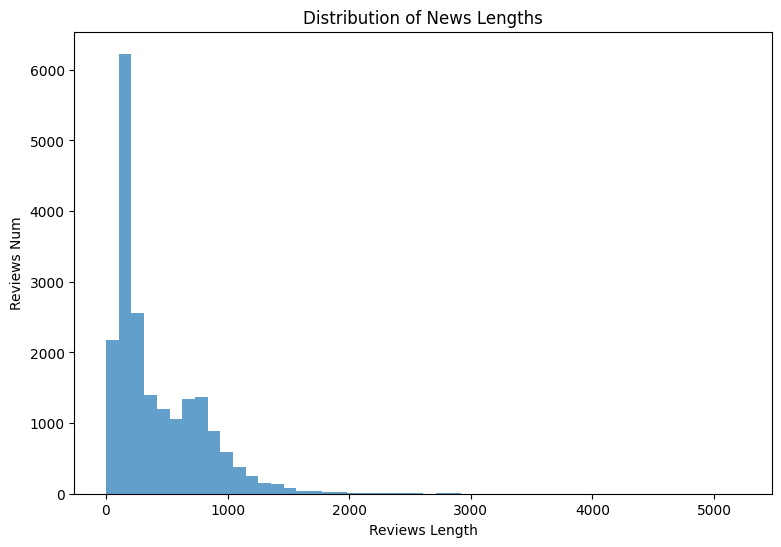

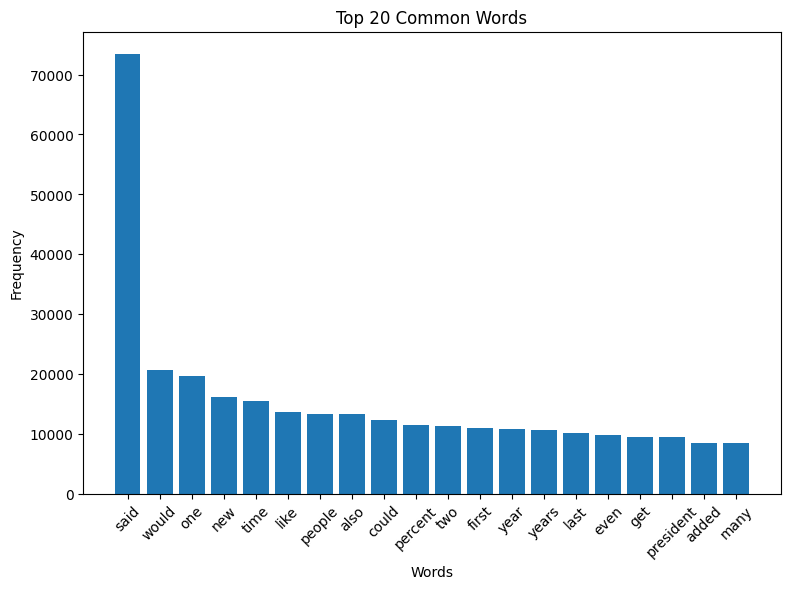

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

print("Class Distribution:")
print(train_data_balanced['label'].value_counts(normalize=True))

review_lengths = train_data_balanced['text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(9, 6))
plt.hist(review_lengths, bins=50, alpha=0.7)
plt.title('Distribution of News Lengths')
plt.xlabel('Reviews Length')
plt.ylabel('Reviews Num')
plt.show()

stop_words = set(stopwords.words('english'))
all_words = [word for review in train_data['text'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

word_freq = Counter(all_words).most_common(20)

words, frequencies = zip(*word_freq)
plt.figure(figsize=(9, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Common Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:
## Preprocess test data

test_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/news_balancedtest.csv', header=None)
test_data.columns=['label', 'text']
test_data = test_data[(test_data['label'] == 1) | (test_data['label']==4)]
print(test_data.value_counts('label'))
test_data_balanced = test_data.copy()
test_data_balanced['label'] = test_data_balanced['label'].replace({1: 0, 4: 1})
test_data_balanced.head()

label
1    750
4    750
Name: count, dtype: int64


,label,text
0,0,When so many actors seem content to churn out ...
1,0,In what football insiders are calling an unex...
2,0,In a freak accident following Game 3 of the N....
3,0,North Koreas official news agency announced to...
4,0,The former Alaska Governor Sarah Palin would b...


In [ ]:
print(test_data_balanced[test_data_balanced['label']==1].iloc[0]['text'])

The Alberta province health minister wants to know if swine flu shots were 'inappropriately diverted' to the Calgary Flames while thousands had to stand in line for hours for the vaccine. Alberta Health Minister Ron Liepert says he doesn't know where the NHL team got the vaccine, adding that Alberta Health Services is the only supplier in the province. Team president Ken King says the club contacted the department and asked for the clinic. Health officials have begun an investigation into the special clinic, which was held for the players and their families last Friday. Liepert says the vaccine would be diverted only with the approval of the chief medical officer of health, but he doesn't know if that was the case. Alberta's opposition parties say professional ice hockey players shouldn't be getting the vaccine ahead of cancer patients and pregnant women. 


# Simple RNN

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def adhoc_test_x(input_string, tokenizer):
  input_df = pd.DataFrame([input_string], columns=['text'])
  input_df['text'] = input_df['text'].apply(remove_stopwords)
  adhoc_test_sequences = tokenizer.texts_to_sequences(input_df['text'])
  adhoc_x_test = pad_sequences(adhoc_test_sequences, maxlen=100)
  return adhoc_x_test

Epoch 1/5
125/125 [==============================] - 24s 181ms/step - loss: 0.5877 - accuracy: 0.6967 - val_loss: 0.4382 - val_accuracy: 0.8217
Epoch 2/5
125/125 [==============================] - 18s 145ms/step - loss: 0.2364 - accuracy: 0.9179 - val_loss: 0.3325 - val_accuracy: 0.8702
Epoch 3/5
125/125 [==============================] - 15s 124ms/step - loss: 0.1002 - accuracy: 0.9682 - val_loss: 0.2760 - val_accuracy: 0.8852
Epoch 4/5
125/125 [==============================] - 16s 128ms/step - loss: 0.0481 - accuracy: 0.9870 - val_loss: 0.2525 - val_accuracy: 0.9222
Epoch 5/5
47/47 [==============================] - 1s 9ms/step


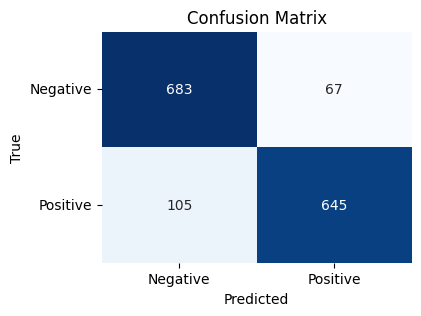

47/47 [==============================] - 0s 9ms/step


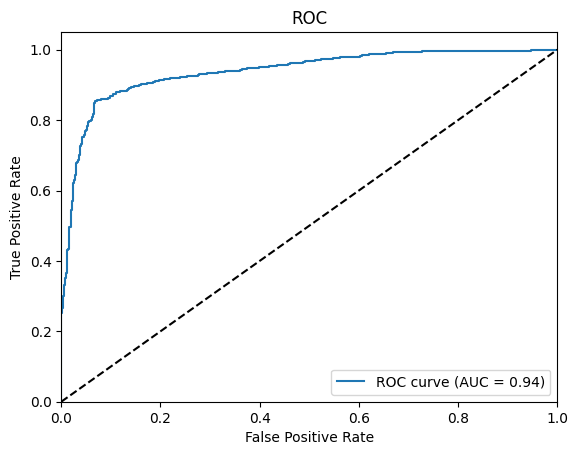

Accuracy: 0.8853, Precision: 0.9059, Recall: 0.8600, F1: 0.8824, AUC: 0.9374


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_data = train_data_balanced.copy()
train_data.columns=['label','text']
test_data = test_data_balanced.copy()

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

#limit set to not run out of ram
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")


In [ ]:
### SAVE
import pickle

with open('news_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('simple_rnn_news')

### LOAD
from tensorflow.keras.models import load_model

with open('news_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

loaded_model = load_model('simple_rnn_news')

In [ ]:
!zip -r /content/simple_rnn_news.zip /content/simple_rnn_news

  adding: content/simple_rnn_news/ (stored 0%)
  adding: content/simple_rnn_news/saved_model.pb (deflated 89%)
  adding: content/simple_rnn_news/assets/ (stored 0%)
  adding: content/simple_rnn_news/variables/ (stored 0%)
  adding: content/simple_rnn_news/variables/variables.index (deflated 60%)
  adding: content/simple_rnn_news/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/simple_rnn_news/fingerprint.pb (stored 0%)
  adding: content/simple_rnn_news/keras_metadata.pb (deflated 86%)


In [ ]:
# Test random string for Simple RNN

test_string_satire = '''
When so many actors seem content to churn out performances for a quick paycheck, a performer who adheres to his principles really stands out. Thats why Jeff Bridges made waves this week when he announced that from now on, he will only perform nude scenes. In an interview in this months GQ, the Big Lebowski star made it clear that he was more than ready to move on to a new phase in his career, leaving his clothed roles in the past. Ive been there and Ive done that, said Bridges, rattling off a laundry list of the films hes appeared in covered up. Now, I can finally afford to only take on roles that excite me. Right now, those are roles with nude scenes. Why waste my time with anything else? Powerful. Though he made it clear that he doesnt regret his previous non-nude roles, Jeff admitted that hed always struggled with pressure from directors and studios to stay clothed on camera. No more towels; no more bathrobes; no more carefully placed plants, he added. Even if my character isnt written as nude, any director I work with will have to figure out how to make him that way. Itll be a challenge for both of us, and one I cant wait to tackle. For their part, Jeffs fans have been nothing but supportive. Wow! Whether or not you agree with him, youve got to have respect for a Hollywood star with that much conviction. You keep doing you, Jeff!
'''

test_string_reliable = '''
The Alberta province health minister wants to know if swine flu shots were 'inappropriately diverted' to the Calgary Flames while thousands had to stand in line for hours for the vaccine. Alberta Health Minister Ron Liepert says he doesn't know where the NHL team got the vaccine, adding that Alberta Health Services is the only supplier in the province. Team president Ken King says the club contacted the department and asked for the clinic. Health officials have begun an investigation into the special clinic, which was held for the players and their families last Friday. Liepert says the vaccine would be diverted only with the approval of the chief medical officer of health, but he doesn't know if that was the case. Alberta's opposition parties say professional ice hockey players shouldn't be getting the vaccine ahead of cancer patients and pregnant women.
'''

print("Satire")
satire_input_x = adhoc_test_x(test_string_satire, loaded_tokenizer)
print(loaded_model.predict(satire_input_x).ravel())

print("Reliable")
reliable_input_x = adhoc_test_x(test_string_reliable, loaded_tokenizer)
print(loaded_model.predict(reliable_input_x).ravel())

Satire
1/1 [==============================] - 0s 130ms/step
[0.00416236]
Reliable
1/1 [==============================] - 0s 22ms/step
[0.9968257]


# LSTM

Epoch 1/5
125/125 [==============================] - 14s 98ms/step - loss: 0.4251 - accuracy: 0.7990 - val_loss: 0.2726 - val_accuracy: 0.8952
Epoch 2/5
125/125 [==============================] - 8s 67ms/step - loss: 0.1244 - accuracy: 0.9602 - val_loss: 0.1895 - val_accuracy: 0.9302
Epoch 3/5
125/125 [==============================] - 5s 37ms/step - loss: 0.0577 - accuracy: 0.9837 - val_loss: 0.1938 - val_accuracy: 0.9342
Epoch 4/5
125/125 [==============================] - 3s 28ms/step - loss: 0.0267 - accuracy: 0.9937 - val_loss: 0.2666 - val_accuracy: 0.9122
Epoch 5/5
47/47 [==============================] - 0s 3ms/step


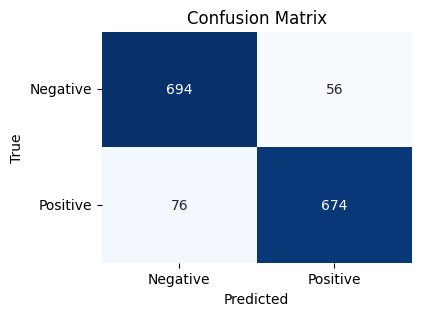

47/47 [==============================] - 0s 3ms/step


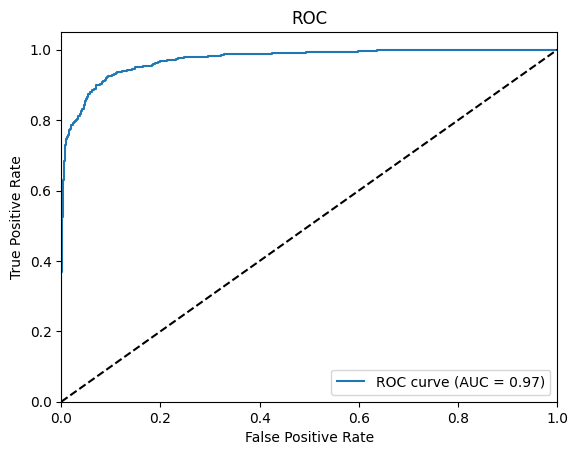

Accuracy: 0.9120, Precision: 0.9233, Recall: 0.8987, F1: 0.9108, AUC: 0.9721


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_data = train_data_balanced.copy()
test_data = test_data_balanced.copy()

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(train_data['text'])
tokenizer = loaded_tokenizer
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [ ]:
### SAVE
model.save('lstm_news')

### LOAD
from tensorflow.keras.models import load_model

lstm_model = load_model('lstm_news')

In [ ]:
# Test random string for Simple RNN

test_string_satire = '''
When so many actors seem content to churn out performances for a quick paycheck, a performer who adheres to his principles really stands out. Thats why Jeff Bridges made waves this week when he announced that from now on, he will only perform nude scenes. In an interview in this months GQ, the Big Lebowski star made it clear that he was more than ready to move on to a new phase in his career, leaving his clothed roles in the past. Ive been there and Ive done that, said Bridges, rattling off a laundry list of the films hes appeared in covered up. Now, I can finally afford to only take on roles that excite me. Right now, those are roles with nude scenes. Why waste my time with anything else? Powerful. Though he made it clear that he doesnt regret his previous non-nude roles, Jeff admitted that hed always struggled with pressure from directors and studios to stay clothed on camera. No more towels; no more bathrobes; no more carefully placed plants, he added. Even if my character isnt written as nude, any director I work with will have to figure out how to make him that way. Itll be a challenge for both of us, and one I cant wait to tackle. For their part, Jeffs fans have been nothing but supportive. Wow! Whether or not you agree with him, youve got to have respect for a Hollywood star with that much conviction. You keep doing you, Jeff!
'''

test_string_reliable = '''
The Alberta province health minister wants to know if swine flu shots were 'inappropriately diverted' to the Calgary Flames while thousands had to stand in line for hours for the vaccine. Alberta Health Minister Ron Liepert says he doesn't know where the NHL team got the vaccine, adding that Alberta Health Services is the only supplier in the province. Team president Ken King says the club contacted the department and asked for the clinic. Health officials have begun an investigation into the special clinic, which was held for the players and their families last Friday. Liepert says the vaccine would be diverted only with the approval of the chief medical officer of health, but he doesn't know if that was the case. Alberta's opposition parties say professional ice hockey players shouldn't be getting the vaccine ahead of cancer patients and pregnant women.
'''

print("Satire")
satire_input_x = adhoc_test_x(test_string_satire, loaded_tokenizer)
print(lstm_model.predict(satire_input_x).ravel())

print("Reliable")
reliable_input_x = adhoc_test_x(test_string_reliable, loaded_tokenizer)
print(lstm_model.predict(reliable_input_x).ravel())

Satire
1/1 [==============================] - 0s 374ms/step
[0.00085022]
Reliable
1/1 [==============================] - 0s 19ms/step
[0.9985056]


In [ ]:
!zip -r /content/lstm_news.zip /content/lstm_news

  adding: content/lstm_news/ (stored 0%)
  adding: content/lstm_news/saved_model.pb (deflated 90%)
  adding: content/lstm_news/assets/ (stored 0%)
  adding: content/lstm_news/variables/ (stored 0%)
  adding: content/lstm_news/variables/variables.index (deflated 60%)
  adding: content/lstm_news/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/lstm_news/fingerprint.pb (stored 0%)
  adding: content/lstm_news/keras_metadata.pb (deflated 86%)


## BiLSTM + CNN

Epoch 1/5
125/125 [==============================] - 20s 103ms/step - loss: 0.4462 - accuracy: 0.7805 - val_loss: 0.3751 - val_accuracy: 0.8414
Epoch 2/5
125/125 [==============================] - 9s 72ms/step - loss: 0.1408 - accuracy: 0.9503 - val_loss: 0.2933 - val_accuracy: 0.8814
Epoch 3/5
125/125 [==============================] - 7s 58ms/step - loss: 0.0584 - accuracy: 0.9825 - val_loss: 0.2180 - val_accuracy: 0.9117
Epoch 4/5
125/125 [==============================] - 5s 44ms/step - loss: 0.0280 - accuracy: 0.9916 - val_loss: 0.2668 - val_accuracy: 0.9107
Epoch 5/5
47/47 [==============================] - 1s 5ms/step


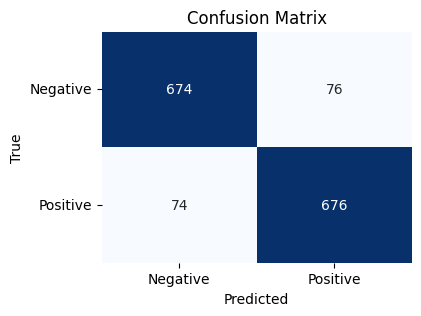

47/47 [==============================] - 0s 4ms/step


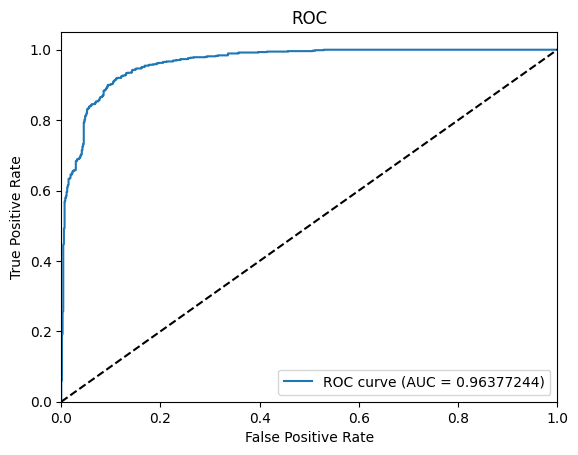

Accuracy: 0.9000, Precision: 0.8989, Recall: 0.9013, F1: 0.9001, AUC: 0.9638


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_data = train_data_balanced.copy()
test_data = test_data_balanced.copy()

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(train_data['text'])
tokenizer = loaded_tokenizer
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    SpatialDropout1D(0.2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.8f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [ ]:
### SAVE
model.save('bilstm_cnn_news')

### LOAD
from tensorflow.keras.models import load_model

bilstm_cnn_model = load_model('bilstm_cnn_news')

In [ ]:
# Test random string for Simple RNN

test_string_satire = '''
When so many actors seem content to churn out performances for a quick paycheck, a performer who adheres to his principles really stands out. Thats why Jeff Bridges made waves this week when he announced that from now on, he will only perform nude scenes. In an interview in this months GQ, the Big Lebowski star made it clear that he was more than ready to move on to a new phase in his career, leaving his clothed roles in the past. Ive been there and Ive done that, said Bridges, rattling off a laundry list of the films hes appeared in covered up. Now, I can finally afford to only take on roles that excite me. Right now, those are roles with nude scenes. Why waste my time with anything else? Powerful. Though he made it clear that he doesnt regret his previous non-nude roles, Jeff admitted that hed always struggled with pressure from directors and studios to stay clothed on camera. No more towels; no more bathrobes; no more carefully placed plants, he added. Even if my character isnt written as nude, any director I work with will have to figure out how to make him that way. Itll be a challenge for both of us, and one I cant wait to tackle. For their part, Jeffs fans have been nothing but supportive. Wow! Whether or not you agree with him, youve got to have respect for a Hollywood star with that much conviction. You keep doing you, Jeff!
'''

test_string_reliable = '''
The Alberta province health minister wants to know if swine flu shots were 'inappropriately diverted' to the Calgary Flames while thousands had to stand in line for hours for the vaccine. Alberta Health Minister Ron Liepert says he doesn't know where the NHL team got the vaccine, adding that Alberta Health Services is the only supplier in the province. Team president Ken King says the club contacted the department and asked for the clinic. Health officials have begun an investigation into the special clinic, which was held for the players and their families last Friday. Liepert says the vaccine would be diverted only with the approval of the chief medical officer of health, but he doesn't know if that was the case. Alberta's opposition parties say professional ice hockey players shouldn't be getting the vaccine ahead of cancer patients and pregnant women.
'''

print("Satire")
satire_input_x = adhoc_test_x(test_string_satire, loaded_tokenizer)
print(bilstm_cnn_model.predict(satire_input_x).ravel())

print("Reliable")
reliable_input_x = adhoc_test_x(test_string_reliable, loaded_tokenizer)
print(bilstm_cnn_model.predict(reliable_input_x).ravel())

Satire
1/1 [==============================] - 1s 778ms/step
[0.00159107]
Reliable
1/1 [==============================] - 0s 20ms/step
[0.9992136]


In [ ]:
!zip -r /content/bilstm_cnn_news.zip /content/bilstm_cnn_news

  adding: content/bilstm_cnn_news/ (stored 0%)
  adding: content/bilstm_cnn_news/saved_model.pb (deflated 91%)
  adding: content/bilstm_cnn_news/assets/ (stored 0%)
  adding: content/bilstm_cnn_news/variables/ (stored 0%)
  adding: content/bilstm_cnn_news/variables/variables.index (deflated 64%)
  adding: content/bilstm_cnn_news/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/bilstm_cnn_news/fingerprint.pb (stored 0%)
  adding: content/bilstm_cnn_news/keras_metadata.pb (deflated 90%)
